In [1]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
import matplotlib.pyplot as plt
from deap import gp
from alpine.gp import gpsymbreg as gps
from alpine.data import Dataset
from dctkit import config
import dctkit
import numpy as np
import ray
import math
import yaml
from typing import Tuple, Callable, List
import numpy.typing as npt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
config()

def eval_MSE_sol(residual: Callable, D: Dataset, S: SimplicialComplex, u_0: C.CochainP0) -> float:

    num_nodes = D.X.shape[1]

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    config()


    # objective: squared norm of the residual of the equation + penalty on Dirichlet 
    # boundary condition on the first node
    def obj(x, y):
        penalty = 100.*x[0]**2
        u = C.CochainP0(S, x)
        f = C.CochainP0(S, y)
        r = residual(u, f)
        total_energy = C.inner(r, r) + penalty
        return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    total_err = 0.

    best_sols = []

    for i, curr_y in enumerate(D.y):
        # set additional arguments of the objective function (apart from the vector of unknowns)
        args = {'y': curr_y}
        prb.set_obj_args(args)

        # minimize the objective
        x = prb.solve(x0=u_0.coeffs.flatten(), ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

        if (prb.last_opt_result == 1 or prb.last_opt_result == 3
                or prb.last_opt_result == 4):

            current_err = np.linalg.norm(x-D.X[i, :])**2
        else:
            current_err = math.nan

        if math.isnan(current_err):
            total_err = 1e5
            break

        total_err += current_err

        best_sols.append(x)

    total_err *= 1/D.X.shape[0]

    return total_err, best_sols

In [3]:
@ray.remote
def predict(individuals_batch: list[gp.PrimitiveSetTyped], toolbox, D: Dataset,
            S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> List[npt.NDArray]:

    best_sols = [None]*len(individuals_batch)

    for i, individual in enumerate(individuals_batch):
        callable = toolbox.compile(expr=individual)
        _, best_sols[i] = eval_MSE_sol(callable, D, S, u_0)

    return best_sols

In [4]:
@ray.remote
def fitness(individuals_batch: list[gp.PrimitiveSetTyped], toolbox, D: Dataset,
                 S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> Tuple[float, ]:

    objvals = [None]*len(individuals_batch)

    for i, individual in enumerate(individuals_batch):
        callable = toolbox.compile(expr=individual)
        # add penalty on length of the tree to promote simpler solutions
        objval, _ = eval_MSE_sol(callable, D, S, u_0) #+ penalty["reg_param"]*indlen)
        objvals[i] = (objval,)

    return objvals

In [5]:
def stgp_poisson():
    with open("example_poisson.yaml") as config_file:
        config_file_data = yaml.safe_load(config_file)

    # generate mesh and dataset
    mesh, _ = generate_line_mesh(num_nodes=11, L=1.)
    S = build_complex_from_mesh(mesh)
    S.get_hodge_star()
    x = S.node_coords 
    num_nodes = S.num_nodes

    # generate training and test datasets
    # exact solution = x² 
    u = C.CochainP0(S, np.array(x[:,0]**2, dtype=dctkit.float_dtype))
    # compute source term such that u solves the discrete Poisson equation 
    # Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
    f = C.laplacian(u)
    f.coeffs *= -1.
    X_train = np.array([u.coeffs.flatten()],dtype=dctkit.float_dtype)
    y_train = np.array([f.coeffs.flatten()], dtype=dctkit.float_dtype)

    # initial guess for the unknown of the Poisson problem (cochain of nodals values)
    u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
    u_0 = C.CochainP0(S, u_0_vec)

    # define primitive set for the residual of the discrete Poisson equation
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)

    # rename arguments of the residual
    pset.renameArguments(ARG0="u")
    pset.renameArguments(ARG1="f")

    penalty = config_file_data["gp"]["penalty"]
    common_params = {'S': S, 'u_0': u_0, 'penalty': penalty}

    gpsr = gps.GPSymbolicRegressor(pset=pset, fitness=fitness.remote,
                                    predict_func=predict.remote, common_data=common_params,
                                    print_log=True, 
                                    config_file_data=config_file_data)



    train_data = Dataset("D", X_train, y_train)
    gpsr.fit(train_data)

    u_best = gpsr.predict(train_data)

    ray.shutdown()
    plt.figure()
    plt.plot(x[:,0], u.coeffs.flatten())
    plt.plot(x[:,0], np.ravel(u_best), "ro")
    plt.show()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


2024-04-17 16:41:59,188	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Generating initial population(s)...
DONE.
 -= START OF EVOLUTION =- 
Evaluating initial population(s)...


(fitness pid=4116492) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DONE.
   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg   	max   	std   	min	avg 	max	std   
1  	100  	0.0327	2.4773	2.5333	0.3542	3  	7.31	19 	4.0017
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0(u)))
2  	100  	0.0327	2.4773	2.5333	0.3542	3  	7.31	19 	4.0017
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0(u)))
3  	100  	0.0327	2.4737	2.5333	0.3555	3  	7.39	19 	3.9947
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0(u)))
4  	100  	0.0327	2.4391	2.5333	0.4339	3  	7.66	21 	4.2993
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0(u)))
5  	100  	0.0327	2.4063	2.5333	0.4473	3  	8.25	23 	4.6997
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0(u)))
6  	100  	0.0327	2.3315	2.5333	0.4593	3  	9.82	23 	5.2314
Best individuals of this generation:
AddCP0(AddCP0(f, u), delP1(cobP0

(fitness pid=4116478) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu. [repeated 23x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


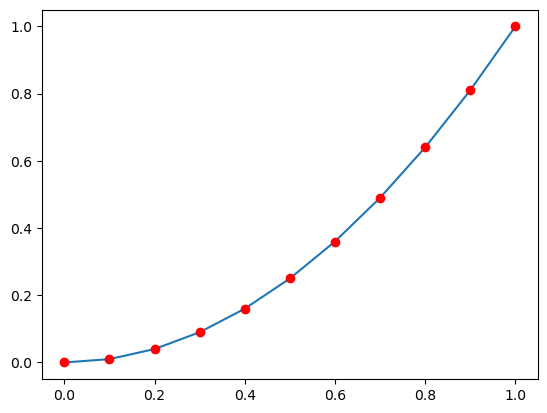

In [6]:
stgp_poisson()
